In [1]:
import sys
!{sys.executable} -m pip install numpy

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
!{sys.executable} -m pip install pandas

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.


In [3]:
!{sys.executable} -m pip install osmnx

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 KB 1.6 MB/s eta 0:00:00m eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 6.6 MB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 7.0 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 7.3 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 4.7 MB/s eta 0:00:005.2 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.3 MB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 814.5/814.5 KB 5.4 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 6.2 MB/s eta 0:00:00m eta 0:00:010:01:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━

In [53]:
!{sys.executable} -m pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.


In [5]:
from osmnx import geocode_to_gdf
from shapely.geometry import Polygon, Point, MultiPolygon, MultiPoint
from shapely.ops import unary_union, polygonize, cascaded_union
from matplotlib.pyplot import plot, figure
from math import pi, sqrt, log, inf

Fontconfig warning: ignoring UTF-8: not a valid region tag
Matplotlib is building the font cache; this may take a moment.


In [54]:
class PolygonMetrics:
    
    def __init__(self, gdf_polygon):   
        self.polygon = self.convert_gdf_to_shapely_polygon(gdf_polygon)
        self.convex_hull_polygon = self.get_convex_hull_polygon(self.polygon) 
        self.min_rot_rect_polygon = self.get_mmr_polygon(self.convex_hull_polygon)        
        self.polygon_metrics = dict()
        
    def convert_gdf_to_shapely_polygon(self, gdf_polygon):
        border_lines = unary_union(gdf_polygon.geometry.values)
        shapely_multipolygon = MultiPolygon(polygonize(border_lines))
        shapely_polygon = cascaded_union([Polygon(component.exterior).buffer(0.01).buffer(-0.01) for component in shapely_multipolygon if len(component.exterior.coords) > 2000])
        return shapely_polygon

    def get_convex_hull_polygon(self, shapely_polygon):
        multipoint_obj = MultiPoint(shapely_polygon.exterior.coords)
        convex_hull_polygon = multipoint_obj.convex_hull
        return convex_hull_polygon
    
    def get_mmr_polygon(self, convex_hull_polygon):
        return convex_hull_polygon.minimum_rotated_rectangle

    def plot_polygon(self, shapely_polygon):
        plot(*shapely_polygon.exterior.xy)     
        
    def extract_poly_coords(self, shapely_polygon):
        if shapely_polygon.type == 'Polygon':
            exterior_coords = shapely_polygon.exterior.coords[:]
            interior_coords = []
            for interior in shapely_polygon.interiors:
                interior_coords += interior.coords[:]
        elif shapely_polygon.type == 'MultiPolygon':
            exterior_coords = []
            interior_coords = []
            for part in shapely_polygon:
                epc = extract_poly_coords(part) 
                exterior_coords += epc['exterior_coords']
                interior_coords += epc['interior_coords']
        else:
            raise ValueError('Unhandled geometry type: ' + repr(shapely_polygon.type))
        return {'exterior_coords': exterior_coords,
                'interior_coords': interior_coords}

    def compute_metrics(self):
        
        polygon_area = self.polygon.area
        polygon_perimeter = self.polygon.length
        
        polygon_convex_hull_area = self.convex_hull_polygon.area
        polygon_convex_hull_perimeter = self.convex_hull_polygon.length
        
        # https://stackoverflow.com/questions/13541562/python-contour-features-in-a-polygon-shapefiles-with-a-straightforward-solution
        p0 = Point(self.min_rot_rect_polygon.exterior.coords[0])
        p1 = Point(self.min_rot_rect_polygon.exterior.coords[1])
        p2 = Point(self.min_rot_rect_polygon.exterior.coords[2])
        d1 = p0.distance(p1)
        d2 = p1.distance(p2)
        polygon_major_axis_length = max(d1, d2)
        polygon_minor_axis_length = min(d1, d2)        
        polygon_contour_length = self.min_rot_rect_polygon.length 
        
        self.polygon_metrics["polygon_area"] = polygon_area
        self.polygon_metrics["polygon_perimeter"] = polygon_perimeter
        
        polygon_coords = extract_poly_coords(self.polygon)
        self.polygon_metrics["total_exterior_coords"] = len(polygon_coords["exterior_coords"])
        self.polygon_metrics["total_interior_coords"] = len(polygon_coords["interior_coords"])
        self.polygon_metrics["total_coords"] = len(polygon_coords["exterior_coords"]) + len(polygon_coords["interior_coords"])
                
        self.polygon_metrics["complexity"] = polygon_convex_hull_perimeter / polygon_perimeter
        
        self.polygon_metrics["solidity"] = polygon_area / polygon_convex_hull_area
        
        self.polygon_metrics["elongation"] = polygon_major_axis_length / polygon_minor_axis_length
        
        self.polygon_metrics["roundness"] = 4 * polygon_area / (pi * (polygon_major_axis_length ** 2))
        
        self.polygon_metrics["rectangular_fitting"] = polygon_area * ( polygon_minor_axis_length / polygon_major_axis_length) 
        
        self.polygon_metrics["compactness"] = sqrt(4 * polygon_area / pi) / polygon_contour_length
        
        self.polygon_metrics["form_factor"] = (4 * pi * polygon_area) / (polygon_perimeter ** 2)
        
        self.polygon_metrics["square_pixel_index"] = 1 - (4 * sqrt(polygon_area)) / polygon_perimeter
        
        self.polygon_metrics["fractal_dimension"] = abs(2 * log(polygon_perimeter / 4) / log(polygon_perimeter))
        
        self.polygon_metrics["shape_index"] = polygon_perimeter / (4 * sqrt(polygon_area))
        
        self.polygon_metrics["amplitude_vibration"] = (polygon_perimeter - polygon_convex_hull_perimeter) / polygon_perimeter
        
        self.polygon_metrics["convex_hull_deviation"] = (polygon_convex_hull_area - polygon_area) /  polygon_convex_hull_area
        
    def get_metrics(self):
        self.compute_metrics()                
        return self.polygon_metrics
    
    def plot_all_polygons(self, x, y):
        figure(figsize=(x,y))
        self.plot_polygon(self.polygon)
        self.plot_polygon(self.convex_hull_polygon)
        self.plot_polygon(self.min_rot_rect_polygon) 

In [55]:
def print_dict(d1):
    for metric in d1:
        if(len(metric) > 15):
            print(metric, end = '\t')
        else:
            print(metric, end = '\t\t')
        print(round(d1[metric], 5))

In [60]:
def get_metrics_for_a_polygon(data_1): 
    data_1_metrics = PolygonMetrics(data_1)
    data_1_metrics_dict = data_1_metrics.get_metrics()
    print_dict(data_1_metrics_dict)
    data_1.plot()

/var/folders/yn/zyt5vw9s0pd434nm202hf2nm0000gr/T/ipykernel_78332/497056943.py:12: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  shapely_polygon = cascaded_union([Polygon(component.exterior).buffer(0.01).buffer(-0.01) for component in shapely_multipolygon if len(component.exterior.coords) > 2000])
/var/folders/yn/zyt5vw9s0pd434nm202hf2nm0000gr/T/ipykernel_78332/497056943.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  shapely_polygon = cascaded_union([Polygon(component.exterior).buffer(0.01).buffer(-0.01) for component in shapely_multipolygon if len(component.exterior.coords) > 2000])


polygon_area		16.12729
polygon_perimeter	36.26423
total_exterior_coords	29938
total_interior_coords	254
total_coords		30192
complexity		0.49339
solidity		0.75006
elongation		1.61427
roundness		0.46516
rectangular_fitting	9.99046
compactness		0.21057
form_factor		0.1541
square_pixel_index	0.55704
fractal_dimension	1.22787
shape_index		2.25755
amplitude_vibration	0.50661
convex_hull_deviation	0.24994


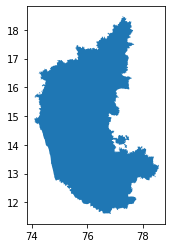

In [61]:
data_1 = geocode_to_gdf('Karnataka, India') 
get_metrics_for_a_polygon(data_1)

/var/folders/yn/zyt5vw9s0pd434nm202hf2nm0000gr/T/ipykernel_78332/497056943.py:12: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  shapely_polygon = cascaded_union([Polygon(component.exterior).buffer(0.01).buffer(-0.01) for component in shapely_multipolygon if len(component.exterior.coords) > 2000])
/var/folders/yn/zyt5vw9s0pd434nm202hf2nm0000gr/T/ipykernel_78332/497056943.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  shapely_polygon = cascaded_union([Polygon(component.exterior).buffer(0.01).buffer(-0.01) for component in shapely_multipolygon if len(component.exterior.coords) > 2000])


polygon_area		26.47061
polygon_perimeter	45.38422
total_exterior_coords	45618
total_interior_coords	314
total_coords		45932
complexity		0.5244
solidity		0.72959
elongation		1.55258
roundness		0.43371
rectangular_fitting	17.04944
compactness		0.20028
form_factor		0.1615
square_pixel_index	0.54654
fractal_dimension	1.27327
shape_index		2.20528
amplitude_vibration	0.4756
convex_hull_deviation	0.27041


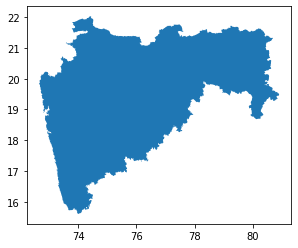

In [65]:
data_2 = geocode_to_gdf('Maharashtra, India') 
get_metrics_for_a_polygon(data_2)

/var/folders/yn/zyt5vw9s0pd434nm202hf2nm0000gr/T/ipykernel_78332/497056943.py:12: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  shapely_polygon = cascaded_union([Polygon(component.exterior).buffer(0.01).buffer(-0.01) for component in shapely_multipolygon if len(component.exterior.coords) > 2000])
/var/folders/yn/zyt5vw9s0pd434nm202hf2nm0000gr/T/ipykernel_78332/497056943.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  shapely_polygon = cascaded_union([Polygon(component.exterior).buffer(0.01).buffer(-0.01) for component in shapely_multipolygon if len(component.exterior.coords) > 2000])


polygon_area		10.77746
polygon_perimeter	23.86093
total_exterior_coords	25119
total_interior_coords	170
total_coords		25289
complexity		0.6327
solidity		0.75812
elongation		1.04444
roundness		0.63523
rectangular_fitting	10.31892
compactness		0.20358
form_factor		0.23788
square_pixel_index	0.44966
fractal_dimension	1.12598
shape_index		1.81706
amplitude_vibration	0.3673
convex_hull_deviation	0.24188


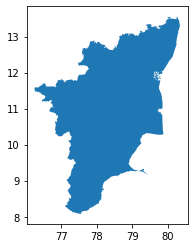

In [66]:
data_3 = geocode_to_gdf('Tamil Nadu, India') 
get_metrics_for_a_polygon(data_3)

/var/folders/yn/zyt5vw9s0pd434nm202hf2nm0000gr/T/ipykernel_78332/497056943.py:12: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  shapely_polygon = cascaded_union([Polygon(component.exterior).buffer(0.01).buffer(-0.01) for component in shapely_multipolygon if len(component.exterior.coords) > 2000])
/var/folders/yn/zyt5vw9s0pd434nm202hf2nm0000gr/T/ipykernel_78332/497056943.py:12: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  shapely_polygon = cascaded_union([Polygon(component.exterior).buffer(0.01).buffer(-0.01) for component in shapely_multipolygon if len(component.exterior.coords) > 2000])


polygon_area		3.21661
polygon_perimeter	14.68326
total_exterior_coords	17866
total_interior_coords	0
total_coords		17866
complexity		0.73072
solidity		0.74479
elongation		4.11315
roundness		0.16422
rectangular_fitting	0.78203
compactness		0.16299
form_factor		0.18748
square_pixel_index	0.51142
fractal_dimension	0.96803
shape_index		2.04674
amplitude_vibration	0.26928
convex_hull_deviation	0.25521


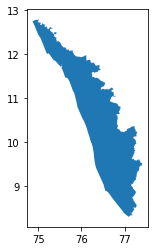

In [67]:
data_4 = geocode_to_gdf('Kerala, India') 
get_metrics_for_a_polygon(data_4)